In [1]:
from volleyball_analysers import *
from sklearn.decomposition import PCA
import tqdm

In [2]:
def load_pose_data(pose_df_path, mappings):
    df = pd.read_excel(pose_df_path, index_col=0)
    df.rename(columns=mappings, inplace=True)
    fps = df['fps'].values[0]
    return df, fps

def get_normalised_kepoints(aggregated_pose_df):
    norm_df = bbox_normalize_joint_coordinates(aggregated_pose_df[[joint + '_x' for joint in joints] + [joint + '_y' for joint in joints]].copy())
    # Normalise the keypoints
    normalised_keypoints_y = np.array([norm_df[joint + '_y_normalized'].values for joint in joints])
    normalised_keypoints_x = np.array([norm_df[joint + '_x_normalized'].values for joint in joints])
    normalised_keypoints_all = np.concatenate([normalised_keypoints_x, normalised_keypoints_y], axis=0)
    return normalised_keypoints_all.T, normalised_keypoints_x.T, normalised_keypoints_y.T

def get_breakpoints(normalised_keypoints, num_phases):
    bkpts_algorithm = rpt.KernelCPD(kernel="rbf", min_size=14)
    bkpts = bkpts_algorithm.fit_predict(normalised_keypoints, n_bkps=num_phases - 1)
    return bkpts

def preprocess_df_for_bpe(aggregated_pose_df):
    annot = pose_df_to_dict(aggregated_pose_df)
    seq = annotations2motion(config.unique_nr_joints, annot['annotations'], scale=1)
    seq = preprocess_sequence(seq)
    return seq

def get_embeddings(seq, window_size, stride):
    seq = preprocess_motion2d_rc(seq, mean_pose_bpe, std_pose_bpe, use_all_joints_on_each_bp=args.use_all_joints_on_each_bp)
    seq = seq.to(config.device)
    seq_features = similarity_analyzer.get_embeddings(seq, video_window_size=window_size, video_stride=stride)
    return seq_features

def compute_dtw_cosine_similarity_per_phase(seq_ref, seq_comp, breakpoints_ref, breakpoints_comp):
    start_ref = 0
    start_comp = 0
    sims_dtw = {}
    sims_dtw_cos = {}
    for i, (end_ref, end_comp) in enumerate(zip(breakpoints_ref, breakpoints_comp)):
        length_ref = end_ref - start_ref
        length_comp = end_comp - start_comp
        seq_ref_features = get_embeddings(seq_ref[:, :, start_ref:end_ref], length_ref, length_ref)
        seq_comp_features = get_embeddings(seq_comp[:, :, start_comp:end_comp], length_comp, length_comp)
        start_ref = end_ref 
        start_comp = end_comp

        sims_dtw[f'phase_{i}'] = {}
        sims_dtw_cos[f'phase_{i}'] = {}
        for bp_i, bp in enumerate(config.body_part_names):
            sims_dtw[f'phase_{i}'][bp] = dtw(seq_ref_features[0][bp_i], seq_comp_features[0][bp_i])
            sims_dtw_cos[f'phase_{i}'][bp] = compute_dtw_cosine_similarity(seq_ref_features[0][bp_i], seq_comp_features[0][bp_i])

    return sims_dtw, sims_dtw_cos

def flatten_results(results):
    rows = []
    for filename, phases in results.items():
        row = {'filename': filename}
        for phase, attributes in phases.items():
            for key, value in attributes.items():
                row[f'{phase}_{key}'] = value
        rows.append(row)
    return rows

In [3]:
joints = [
    'right_shoulder', 'right_elbow', 'right_wrist', 
    'nose', 
    'left_shoulder', 'left_elbow', 'left_wrist', 
    'right_hip', 'right_knee', 'right_ankle', 
    'left_hip', 'left_knee', 'left_ankle'
    ]

MODEL_PATH = 'model_data/pretrained_model/model/model_best.pth.tar'

REFERENCE_DF_PATH = 'attack_pose_data/DATASETS/Techniek_aanval_met_sprong_Ref_POSE_tabel.xlsx'

MAPPINGS = json.load(open('attack_pose_data/translation_mappings.json'))

NUM_PHASES = 4

## Choose number of breakpoints by reference video

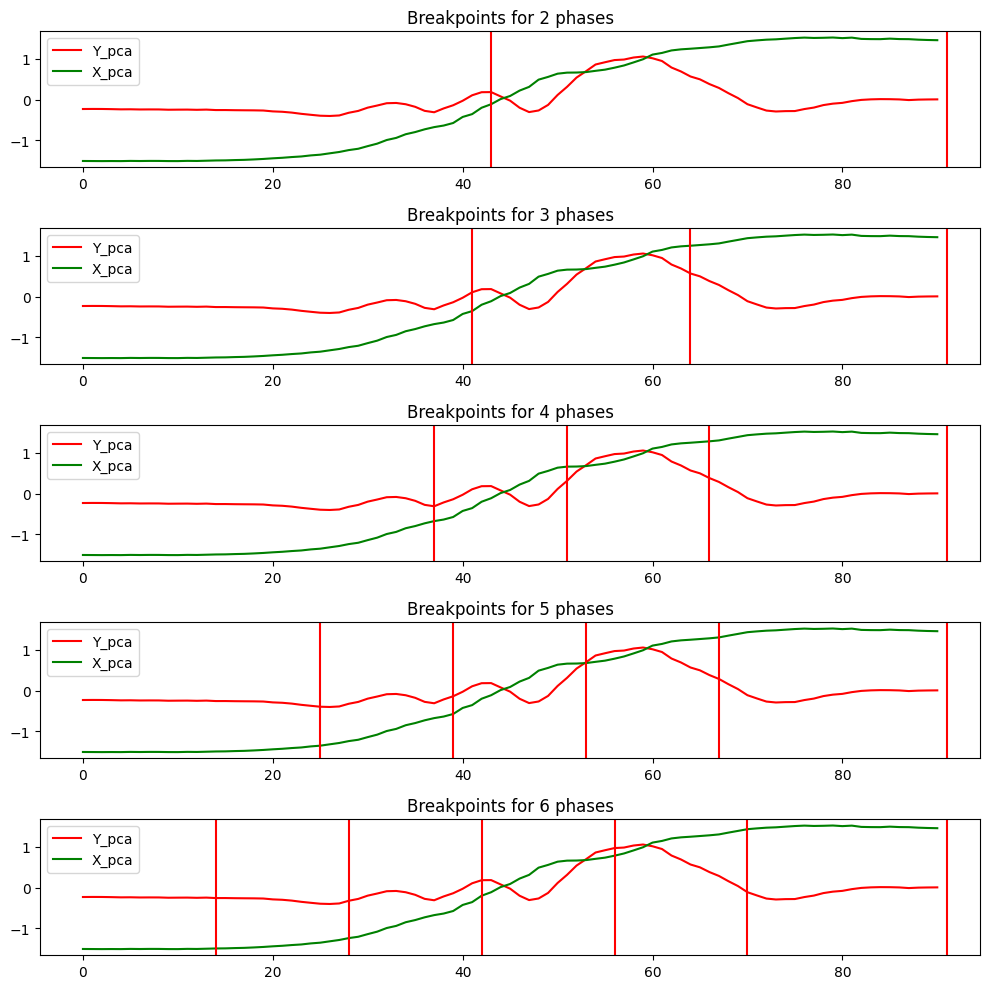

In [4]:
# define the breakpoints to try out (number of phases will be the number of breakpoints + 1)
BREAKPOINTS_TO_TRY_OUT = [2, 3, 4, 5, 6, 7, 8, 9]

ref_df, ref_fps = load_pose_data(REFERENCE_DF_PATH, MAPPINGS)
agg_ref_df, ref_index = aggregate_all_numeric_columns(ref_df, ref_fps, ref_fps)

max_bkpts = len(agg_ref_df) // 14 + 1
bkpts_to_try_out_filtered = [num_phases for num_phases in BREAKPOINTS_TO_TRY_OUT if num_phases < max_bkpts]

norm_keypoints_ref, norm_keypoints_x, norm_keypoints_y = get_normalised_kepoints(agg_ref_df)

fig, ax = plt.subplots(len(bkpts_to_try_out_filtered), 1, figsize=(10, 10))
for i, num_phases in enumerate(bkpts_to_try_out_filtered):
    # Compute breakpoints for reference data
    ref_bktps = get_breakpoints(norm_keypoints_ref, num_phases)

    # Plot the breakpoints and the pca of the keypoints for better visualisation
    pca = PCA(n_components=1)
    Y = pca.fit_transform(norm_keypoints_y)

    pca = PCA(n_components=1)
    X = pca.fit_transform(norm_keypoints_x)

    ax[i].set_title(f'Breakpoints for {num_phases} phases')

    ax[i].plot(Y, label='Y_pca', color='r')
    ax[i].plot(X, label='X_pca', color='g')

    for bkp in ref_bktps:
        ax[i].axvline(bkp, color='r')

    ax[i].legend()

fig.tight_layout()

In [5]:
NUM_PHASES = 4

## Compute breakpoints and phase similarities for rest of the comaprison videos

In [6]:
# Load analysis scripts

args = config_parser()
config = Config(args)
similarity_analyzer = SimilarityAnalyzer(config, MODEL_PATH)
mean_pose_bpe = np.load(os.path.join(args.data_dir, 'meanpose_rc_with_view_unit64.npy'))
std_pose_bpe = np.load(os.path.join(args.data_dir, 'stdpose_rc_with_view_unit64.npy'))

In [7]:
COMPARED_VIDEOS_FOLDER = 'attack_pose_data/DATASETS/'

In [17]:
ref_df, ref_fps = load_pose_data(REFERENCE_DF_PATH, MAPPINGS)
agg_ref_df, _ = aggregate_all_numeric_columns(ref_df, ref_fps, ref_fps)
agg_ref_norm_keypoints, _, _ = get_normalised_kepoints(agg_ref_df)
agg_ref_bkpts = get_breakpoints(agg_ref_norm_keypoints, NUM_PHASES)
agg_ref_seq = preprocess_df_for_bpe(agg_ref_df)

In [18]:
results = {}

for file in tqdm.tqdm(os.listdir(COMPARED_VIDEOS_FOLDER)):
    comp_path = os.path.join(COMPARED_VIDEOS_FOLDER, file)

    comp_df, comp_fps = load_pose_data(comp_path, MAPPINGS)
    agg_comp_df, _ = aggregate_all_numeric_columns(comp_df, comp_fps, ref_fps)
    agg_comp_norm_keypoints, _, _ = get_normalised_kepoints(agg_comp_df)
    agg_comp_bkpts = get_breakpoints(agg_comp_norm_keypoints, NUM_PHASES)
    agg_comp_seq = preprocess_df_for_bpe(agg_comp_df)

    _, similarities_per_phase = compute_dtw_cosine_similarity_per_phase(agg_ref_seq, agg_comp_seq, agg_ref_bkpts, agg_comp_bkpts)
    
    results[file] = similarities_per_phase

100%|██████████| 199/199 [01:11<00:00,  2.78it/s]


In [19]:
results_df = pd.DataFrame(flatten_results(results))
results_df.head()
results_df.to_excel('attack_pose_data/phases_bpe_results.xlsx', index=False)

In [20]:
results_df

,filename,phase_0_ra,phase_0_la,phase_0_rl,phase_0_ll,phase_0_torso,phase_1_ra,phase_1_la,phase_1_rl,phase_1_ll,...,phase_2_ra,phase_2_la,phase_2_rl,phase_2_ll,phase_2_torso,phase_3_ra,phase_3_la,phase_3_rl,phase_3_ll,phase_3_torso
0,GX010054_Clip_127_POSE_tabel.xlsx,0.763415,0.852716,0.736038,0.756180,0.763801,0.833600,0.786766,0.879524,0.718499,...,0.799288,0.867056,0.820225,0.779725,0.838873,0.647599,0.635339,0.799777,0.449795,0.564492
1,GX010053_Clip_37_POSE_tabel.xlsx,0.793099,0.832418,0.757269,0.787612,0.817353,0.758486,0.705944,0.870294,0.711318,...,0.873445,0.796476,0.824529,0.757044,0.837348,0.832039,0.796846,0.838394,0.738666,0.737611
2,GX010044_Clip_14_POSE_tabel.xlsx,0.846875,0.884999,0.738126,0.787505,0.827091,0.887761,0.806654,0.893584,0.697581,...,0.886070,0.880361,0.788680,0.731157,0.876108,0.836189,0.957887,0.792235,0.740877,0.851636
3,GX010055_Clip_102_POSE_tabel.xlsx,0.833580,0.837835,0.890660,0.802904,0.828350,0.865507,0.860337,0.887320,0.696183,...,0.829893,0.850738,0.880245,0.773903,0.831890,0.852004,0.815927,0.800584,0.736281,0.767090
4,GX010055_Clip_199_POSE_tabel.xlsx,0.847723,0.846179,0.794417,0.803316,0.773246,0.784817,0.799234,0.870324,0.715817,...,0.837533,0.798451,0.816841,0.785719,0.806881,0.799060,0.781708,0.834850,0.820852,0.669236
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194,GX010040_Clip_2_sec_6_POSE_tabel.xlsx,0.823344,0.909856,0.655344,0.763512,0.820567,0.808984,0.741620,0.756532,0.665974,...,0.762412,0.810577,0.801629,0.763665,0.843724,0.762767,0.855255,0.819332,0.788563,0.877076
195,GX010055_Clip_164_POSE_tabel.xlsx,0.826129,0.823532,0.716562,0.813605,0.689796,0.771204,0.795125,0.898156,0.750288,...,0.757080,0.878718,0.847371,0.776361,0.822083,0.856886,0.734402,0.800147,0.700055,0.777763
196,GX020054_Clip_15_POSE_tabel.xlsx,0.816544,0.820578,0.728465,0.810444,0.739022,0.843363,0.818628,0.900392,0.681966,...,0.804356,0.849193,0.852921,0.774431,0.821116,0.732308,0.783221,0.723382,0.737829,0.723399
197,GX010045_Clip_0_POSE_tabel.xlsx,0.848082,0.812274,0.804527,0.737042,0.803123,0.894586,0.756397,0.823388,0.699718,...,0.846988,0.802224,0.802834,0.854099,0.868361,0.741821,0.825011,0.900655,0.811019,0.815787


In [22]:
results_df.iloc[:, 1:].min().min(), results_df.iloc[:, 1:].max().max()

(0.4392471, 1.0000002)